1.2:
    1) Use a custom image data generator which takes in DICOM images.
        a) Load the CSV file you saved in Part 1 in a pandas DataFrame
        b) Split n the DataFrame into train, test DataFrame using the function train_test_split(test_size=0.2) from the sklearn.model_selection library
        c) add train/ test/ validation data augmentation parameters in a dictionary form or use the Keras preprocessing function.
        d) Set training/ test/ validation parameters such as BATCH_SIZE, CLASS_MODE, COLOR_MODE, TARGET_SIZE, and EPOCHS.
        e) Create a data generator class for reading in DICOM images or use the class provided. With this custom datagenerator class create a train and validation generator.
    2) Build a VGG 16 model from scratch and train using X-ray images
        a) Build the VGG16 model from scratch using correct layers and activations.
        b) Compile the model and check model summary.
        c) Using the model.fit_generator function of Keras, train the model using the train_generator and validation_generator you built.
        d) Plot the training loss. accuracy, and validation loss. and accuracy values vs. epochs.
        e) Load a set of 9 random images from the test_generator, run model.predict on them. and visualize the prediction scores along with the test images

(1)(a)

In [1]:
import pandas as pd

csv_file = '/media/ricardo/hd1/Ricardo/uca/COVID-19_Radiography_Dataset/DICOM/dicomReduced.csv'

df = pd.read_csv(csv_file, dtype=str)
df.head()

,image_path,target
0,/media/ricardo/hd1/Ricardo/uca/COVID-19_Radiog...,1
1,/media/ricardo/hd1/Ricardo/uca/COVID-19_Radiog...,1
2,/media/ricardo/hd1/Ricardo/uca/COVID-19_Radiog...,1
3,/media/ricardo/hd1/Ricardo/uca/COVID-19_Radiog...,1
4,/media/ricardo/hd1/Ricardo/uca/COVID-19_Radiog...,1


(1)(b)

In [2]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

(1)(c)(d)(e) While dealing with how to preprocessing images in Keras with DICOM, Googled "keras dicom images preprocessing" to reach https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165 ... When I checked solutions, I get very similar code.

In [3]:
import numpy as np
import pandas as pd
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

# tested on tf 2.1 

class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
              
        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array
    
      
# read data
# Assuming it has two cols:
# image_path: path to each image with its extension
# target: labels (here it is 0s and 1s) -> binary classification
#done!
#df = pd.read_csv("yourDfPath.csv", dtype=str)

# split for testing
# done!
#train_df, test_df = train_test_split(df, test_size=0.2)

# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 10
SEED = 1337

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}

# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


train_generator = DCMDataFrameIterator(dataframe=train,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=train_augmenter,
                             **train_consts)

valid_generator = DCMDataFrameIterator(dataframe=train,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=valid_augmenter,
                             **valid_consts)


Found 192 validated image filenames belonging to 2 classes.
Found 47 validated image filenames belonging to 2 classes.


(1)(f)

In [4]:
from tensorflow.keras.models import Sequential
model = Sequential()

(2)(a) Bibliography in live project helps to understand concepts, but in order to implement from scratch a VGG16 model this tutorial was much more useful: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
Comparing with solutions provided is too similar.

In [5]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import tensorflow as tf

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="sigmoid"))

In [6]:
from tensorflow.keras.optimizers import Adam, SGD
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0

In [ ]:
(2)(c)

In [7]:
# training
history = model.fit_generator(
	generator=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=EPOCHS,
	validation_data=valid_generator,
	validation_steps=len(valid_generator)
)

/home/ricardo/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6/6 [==============================] - 126s 22s/step - loss: 0.8815 - accuracy: 0.5521 - val_loss: 0.7372 - val_accuracy: 0.3191
Epoch 2/10
6/6 [==============================] - 128s 22s/step - loss: 0.6748 - accuracy: 0.6198 - val_loss: 0.6080 - val_accuracy: 0.6809
Epoch 3/10
6/6 [==============================] - 155s 28s/step - loss: 0.6069 - accuracy: 0.6823 - val_loss: 0.5947 - val_accuracy: 0.6809
Epoch 4/10
6/6 [==============================] - 136s 23s/step - loss: 0.5960 - accuracy: 0.6875 - val_loss: 0.5732 - val_accuracy: 0.6809
Epoch 5/10
6/6 [==============================] - 132s 23s/step - loss: 0.6019 - accuracy: 0.6823 - val_loss: 0.5603 - val_accuracy: 0.7234
Epoch 6/10
6/6 [==============================] - 138s 23s/step - loss: 0.5849 - accuracy: 0.7031 - val_loss: 0.5406 - val_accuracy: 0.6809
Epoch 7/10
6/6 [==============================] - 138s 23s/step - loss: 0.6057 - accuracy: 0.6823 - val_loss: 0.5200 - val_accuracy: 0.7660
Epoch 8/10
6/6 [====

NameError: name 'test_df' is not defined

(2)(e)

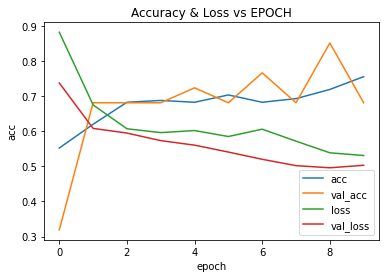

In [13]:
import matplotlib.pyplot as plot
plot.plot(history.history["accuracy"])
plot.plot(history.history['val_accuracy'])
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title("Accuracy & Loss vs EPOCH")
plot.ylabel("acc")
plot.xlabel("epoch")
plot.legend(["acc","val_acc","loss","val_loss"])
plot.show()

In [ ]:
(2)(f)

In [14]:
# Using the testing generator to evaluate the model after training
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)
test_generator = DCMDataFrameIterator(dataframe=test,
                             x_col='image_path',
                             y_col='target',
                             image_data_generator=test_augmenter,
                             **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

Found 60 validated image filenames belonging to 2 classes.
60/60 [==============================] - 8s 138ms/step - loss: 0.6328 - accuracy: 0.6167


Prediction: 
Covid 0.70979595


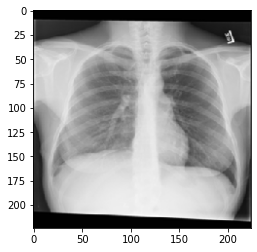

In [44]:
x, y = test_generator.next()
run = model.predict(np.expand_dims(x[0], axis=0))[0]
print("Prediction: ")

if run[0] > run[1]:
    print("Covid " + str(run[0]))
else:
    print("Normal" + str(run[1]))

plot.imshow(x[0])